In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
tf.__version__

'1.15.0'

In [14]:
!pip install -q imageio

In [2]:
import glob, imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

In [11]:
import tensorflow as tf
import keras
from keras.preprocessing.image import load_img, img_to_array, save_img

# 변환하려는 이미지 경로
target_image_path = '../GAN/data/test.jpg'
# 스타일 이미지 경로
style_reference_image_path = '../GAN/data/images.jpg'

# 생성된 사진의 차원
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)


AttributeError: 'Image' object has no attribute 'shape'

In [7]:
(train_images, train_labels),(_,_) = style_reference_image_path
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_images[0].shape

ValueError: too many values to unpack (expected 2)

In [17]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256


In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [19]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [20]:
generator = make_generator_model()

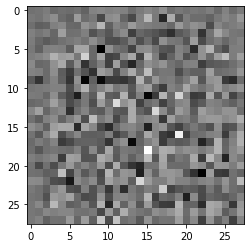

In [21]:
noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [26]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
    
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [27]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00074895]], shape=(1, 1), dtype=float32)


In [28]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [29]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_ouput), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [30]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [31]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [33]:
checkpoint_dir = './training_checkpoints'
checkpoint_prifix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discrimiator_optimizer=discriminator_optimizer,
                                generator = generator, discriminator = discriminator)

In [37]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16


In [38]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [39]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)
        
        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape,gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gernerator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [44]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

    for image_batch in dataset:
        train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,epoch + 1,seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,epochs,
                           seed)
